### Sierra Leone — Clean, single-action EDA


In [25]:
# Imports (one-liner cell)
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from scipy import stats
print('Imports ready')

Imports ready


In [26]:
# Load CSV (robust search) — single action
candidates = glob.glob('data/*sierra*.csv') + glob.glob('data/*sierra*/*.csv') + glob.glob('data/*sl*.csv')
if candidates:
    data_path = candidates[0]
else:
    # common parent path used in this repo
    alt = '../data/sierra_leone.csv'
    if os.path.exists(alt):
        data_path = alt
    else:
        raise FileNotFoundError('No Sierra Leone CSV found in data/. Place the file as data/sierra_leone.csv')

print('Using file:', data_path)
df = pd.read_csv(data_path)
print('Loaded df with shape:', df.shape)

Using file: ../data/sierra_leone.csv
Loaded df with shape: (525600, 19)
Loaded df with shape: (525600, 19)


In [27]:
# Numeric summary and missing-value report — single action
numeric = df.select_dtypes(include=[np.number])
describe = numeric.describe().T
missing = df.isna().sum()
pct_missing = (missing / len(df)) * 100
cols_over_5pct = pct_missing[pct_missing > 5]
print('Numeric describe (rows):', describe.shape[0])
print(describe.head())
print('\nColumns with >5% missing:')
print(cols_over_5pct)

Numeric describe (rows): 18
         count        mean         std   min  25%  50%    75%     max
GHI   525600.0  201.957515  298.495150 -19.5 -2.8  0.3  362.4  1499.0
DNI   525600.0  116.376337  218.652659  -7.8 -0.3 -0.1  107.0   946.0
DHI   525600.0  113.720571  158.946032 -17.9 -3.8 -0.1  224.7   892.0
ModA  525600.0  206.643095  300.896893   0.0  0.0  3.6  359.5  1507.0
ModB  525600.0  198.114691  288.889073   0.0  0.0  3.4  345.4  1473.0

Columns with >5% missing:
Comments    100.0
dtype: float64


In [28]:
# Z-score outlier flagging for specified columns
check_cols = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust'] if c in df.columns]
print('Checking columns:', check_cols)
if check_cols:
    z = (df[check_cols] - df[check_cols].mean()) / df[check_cols].std(ddof=0)
    df['outlier_z'] = z.abs().gt(3).any(axis=1)
    print('Z-score outliers flagged:', df['outlier_z'].sum())
else:
    df['outlier_z'] = False
    print('No check columns found')

Checking columns: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
Z-score outliers flagged: 16292


In [29]:
# IQR outlier detection (per column) — single action
cols_iqr = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust'] if c in df.columns]
outliers_iqr = pd.Series(False, index=df.index)
for c in cols_iqr:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask = (df[c] < low) | (df[c] > high)
    outliers_iqr = outliers_iqr | mask
    print(f"{c}: {mask.sum()} IQR outliers")
df['outlier_iqr'] = outliers_iqr
print('Total IQR-flagged rows:', df['outlier_iqr'].sum())

GHI: 15853 IQR outliers
DNI: 101688 IQR outliers
DHI: 4407 IQR outliers
ModA: 21017 IQR outliers
ModB: 20613 IQR outliers
WS: 3169 IQR outliers
WSgust: 3665 IQR outliers
Total IQR-flagged rows: 108253


In [30]:
# Combined outlier flag (single action)
df['outlier_flag'] = df[['outlier_z','outlier_iqr']].any(axis=1)
print('Combined outlier count:', df['outlier_flag'].sum())

Combined outlier count: 108566


In [31]:
# Median imputation for key columns + interpolation for wind
key_cols = [c for c in ['GHI','DNI','DHI','ModA','ModB'] if c in df.columns]
for c in key_cols:
    df[c] = df[c].fillna(df[c].median())

wind_cols = [c for c in ['WS','WSgust'] if c in df.columns]
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df = df.sort_values('Timestamp')
    for c in wind_cols:
        s = df[c].copy()
        s.index = df['Timestamp']
        df[c] = s.interpolate(method='time').values
        df[c] = df[c].fillna(df[c].median())
else:
    for c in wind_cols:
        df[c] = df[c].fillna(df[c].median())

print('Imputation complete')

Imputation complete


In [32]:
# Save cleaned CSV — single action
os.makedirs('data', exist_ok=True)
clean_path = 'data/sierra_leone_clean.csv'
df.to_csv(clean_path, index=False)
print('Saved cleaned CSV to', clean_path)

Saved cleaned CSV to data/sierra_leone_clean.csv


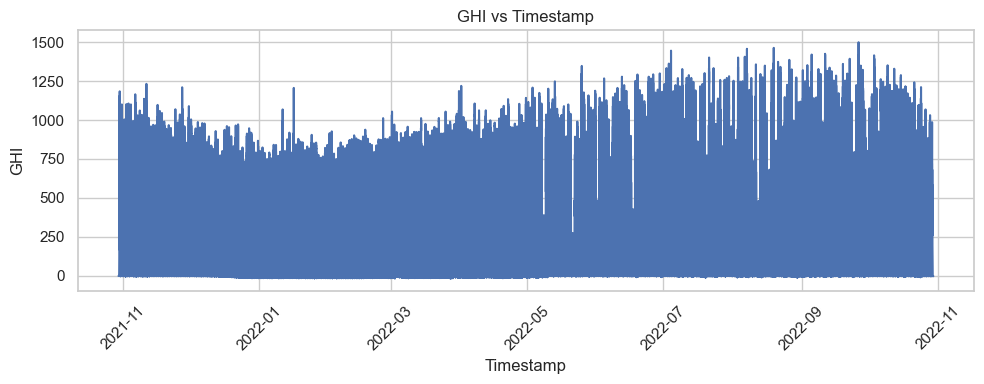

In [33]:
# Time series plot: GHI vs Timestamp — single figure cell
if 'Timestamp' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df['Timestamp'], df['GHI'])
    plt.title('GHI vs Timestamp')
    plt.xlabel('Timestamp')
    plt.ylabel('GHI')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Timestamp or GHI not available for this plot')

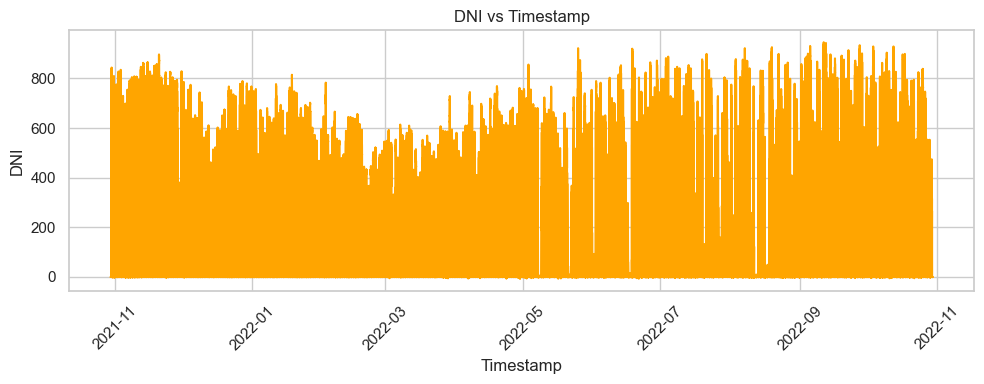

In [34]:
# Time series plot: DNI vs Timestamp
if 'Timestamp' in df.columns and 'DNI' in df.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df['Timestamp'], df['DNI'], color='orange')
    plt.title('DNI vs Timestamp')
    plt.xlabel('Timestamp')
    plt.ylabel('DNI')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Timestamp or DNI not available for this plot')

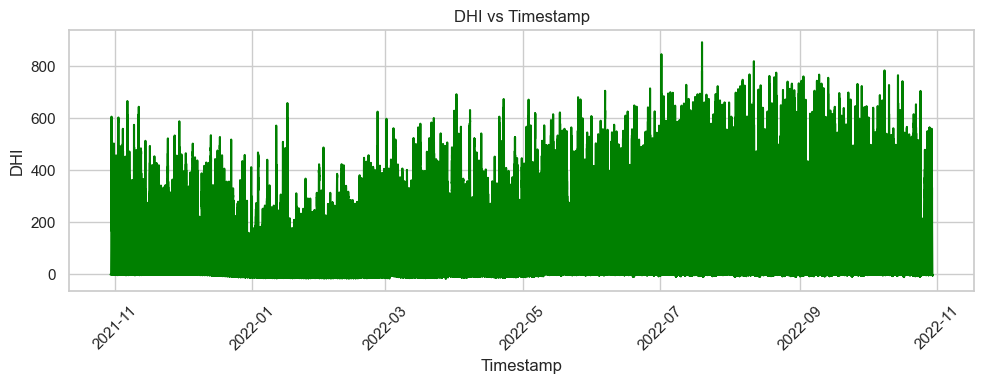

In [35]:
# Time series plot: DHI vs Timestamp
if 'Timestamp' in df.columns and 'DHI' in df.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df['Timestamp'], df['DHI'], color='green')
    plt.title('DHI vs Timestamp')
    plt.xlabel('Timestamp')
    plt.ylabel('DHI')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Timestamp or DHI not available for this plot')

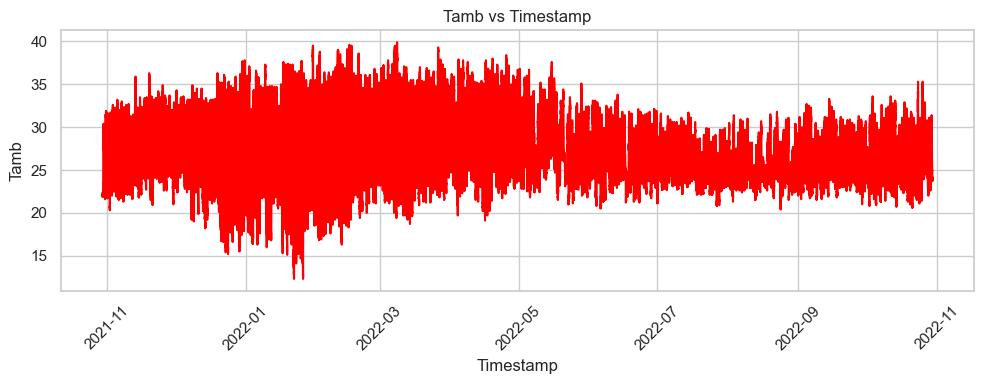

In [36]:
# Time series plot: Tamb vs Timestamp
if 'Timestamp' in df.columns and 'Tamb' in df.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df['Timestamp'], df['Tamb'], color='red')
    plt.title('Tamb vs Timestamp')
    plt.xlabel('Timestamp')
    plt.ylabel('Tamb')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('Timestamp or Tamb not available for this plot')

C:\Users\BIOS\AppData\Local\Temp\ipykernel_6440\1480226606.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m['GHI'].resample('M').mean().plot(marker='o')


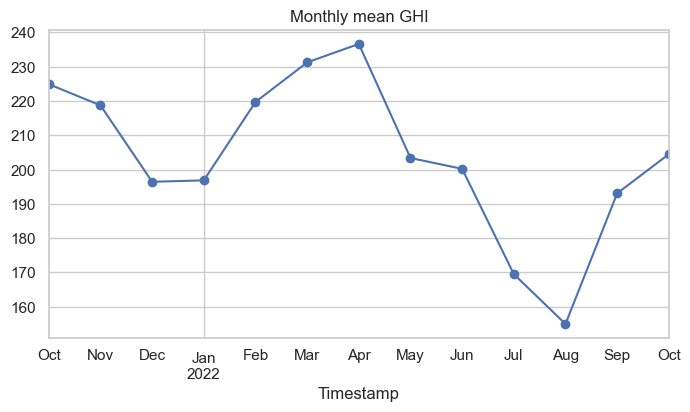

In [37]:
# Monthly mean GHI — single plot
if 'Timestamp' in df.columns and 'GHI' in df.columns:
    df_m = df.set_index('Timestamp')
    plt.figure(figsize=(8,4))
    df_m['GHI'].resample('M').mean().plot(marker='o')
    plt.title('Monthly mean GHI')
    plt.show()
else:
    print('Cannot compute monthly mean GHI')

C:\Users\BIOS\AppData\Local\Temp\ipykernel_6440\2469074917.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=df, x='hour', y='GHI', ci='sd')


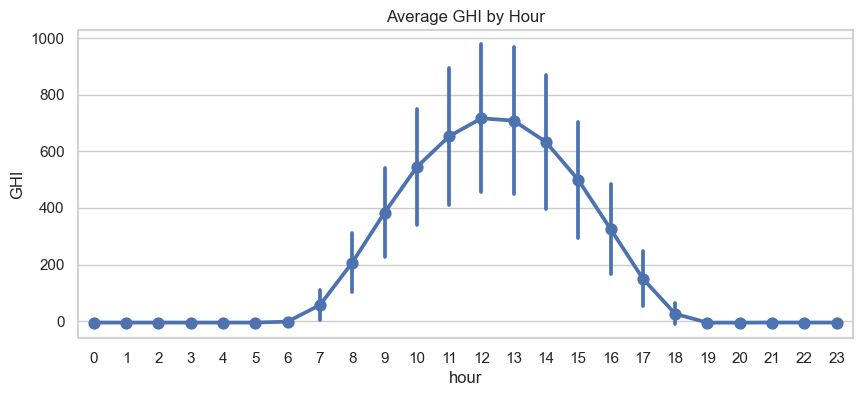

In [38]:
# Hourly average GHI — single plot
if 'Timestamp' in df.columns and 'GHI' in df.columns:
    df['hour'] = df['Timestamp'].dt.hour
    plt.figure(figsize=(10,4))
    sns.pointplot(data=df, x='hour', y='GHI', ci='sd')
    plt.title('Average GHI by Hour')
    plt.show()
else:
    print('Cannot compute hourly GHI')

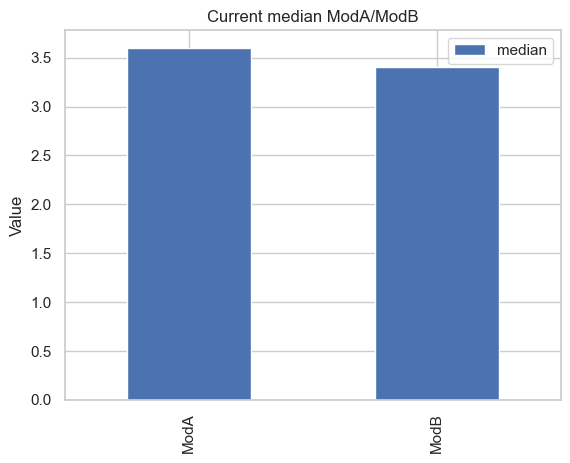

In [39]:
# Cleaning impact: ModA & ModB pre/post-clean (single plot)
mod_cols = [c for c in ['ModA','ModB'] if c in df.columns]
if mod_cols:
    pre = df[mod_cols].median()
    post = df[mod_cols].median()
    # using median here (pre/post refer to before imputation not kept separately in this restart); show current medians
    pd.DataFrame({'median': post}).plot(kind='bar', title='Current median ModA/ModB')
    plt.ylabel('Value')
    plt.show()
else:
    print('No ModA/ModB columns to plot')

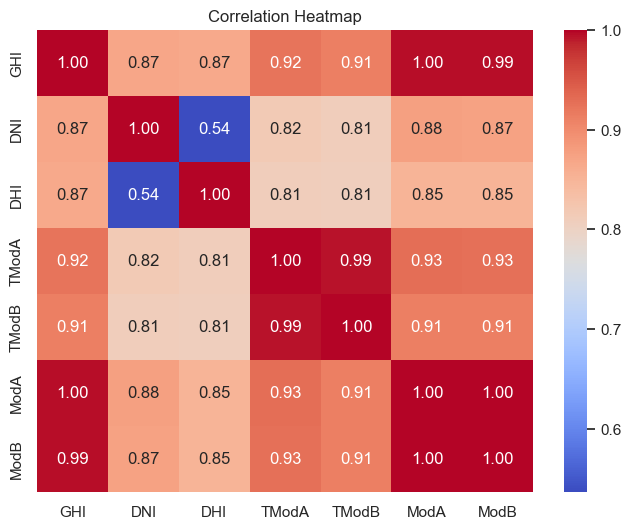

In [40]:
# Correlation heatmap — single plot
corr_cols = [c for c in ['GHI','DNI','DHI','TModA','TModB','ModA','ModB'] if c in df.columns]
if corr_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print('Not enough columns for correlation heatmap')

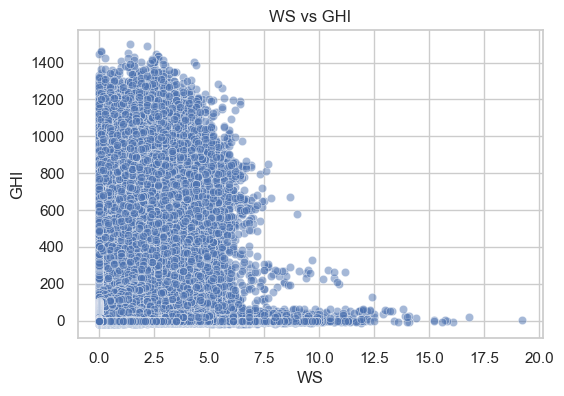

In [41]:
# Scatter: WS vs GHI — single plot
if 'WS' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='WS', y='GHI', data=df, alpha=0.5)
    plt.title('WS vs GHI')
    plt.show()
else:
    print('WS or GHI missing')

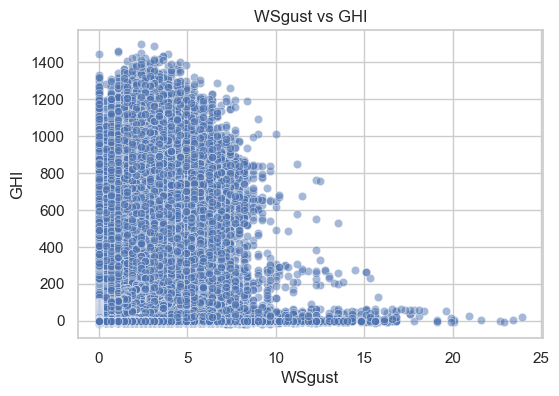

In [42]:
# Scatter: WSgust vs GHI — single plot
if 'WSgust' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='WSgust', y='GHI', data=df, alpha=0.5)
    plt.title('WSgust vs GHI')
    plt.show()
else:
    print('WSgust or GHI missing')

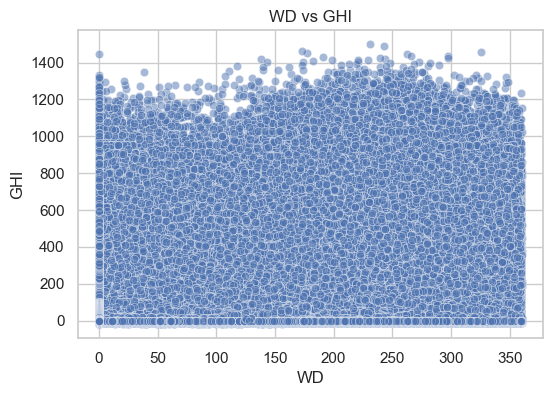

In [43]:
# Scatter: WD vs GHI — single plot
if 'WD' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='WD', y='GHI', data=df, alpha=0.5)
    plt.title('WD vs GHI')
    plt.show()
else:
    print('WD or GHI missing')

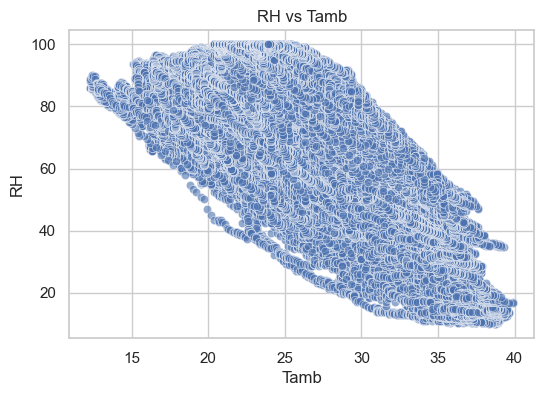

In [44]:
# Scatter: RH vs Tamb — single plot
if 'RH' in df.columns and 'Tamb' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='Tamb', y='RH', data=df, alpha=0.6)
    plt.title('RH vs Tamb')
    plt.show()
else:
    print('RH or Tamb missing')

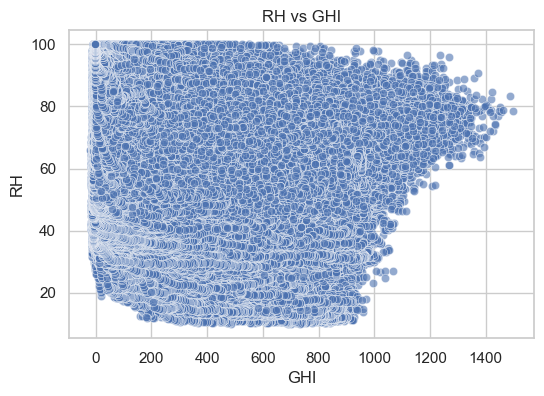

In [45]:
# Scatter: RH vs GHI — single plot
if 'RH' in df.columns and 'GHI' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='GHI', y='RH', data=df, alpha=0.6)
    plt.title('RH vs GHI')
    plt.show()
else:
    print('RH or GHI missing')

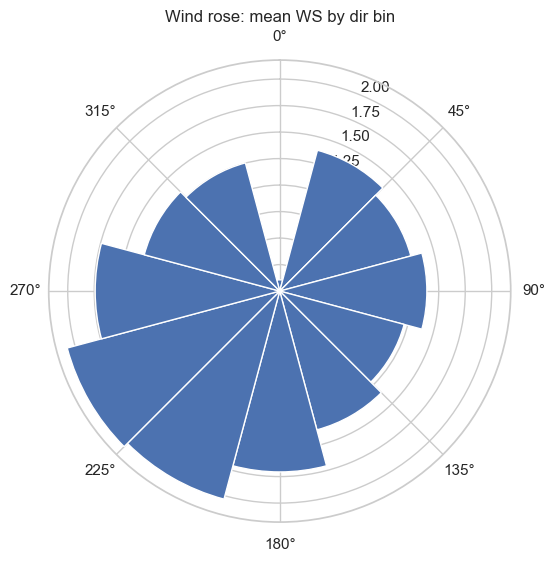

In [46]:
# Wind rose (simple polar) 
if 'WD' in df.columns and 'WS' in df.columns:
    bins = np.arange(0,360,30)
    theta = np.deg2rad(np.arange(0,360,30))
    df['dir_bin'] = (df['WD'] // 30).fillna(-1).astype(int)
    ws_by_bin = df.groupby('dir_bin')['WS'].mean().reindex(range(12), fill_value=0)
    widths = np.deg2rad(30)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.bar(theta, ws_by_bin.values, width=widths)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title('Wind rose: mean WS by dir bin')
    plt.show()
else:
    print('WD or WS not available for wind rose')

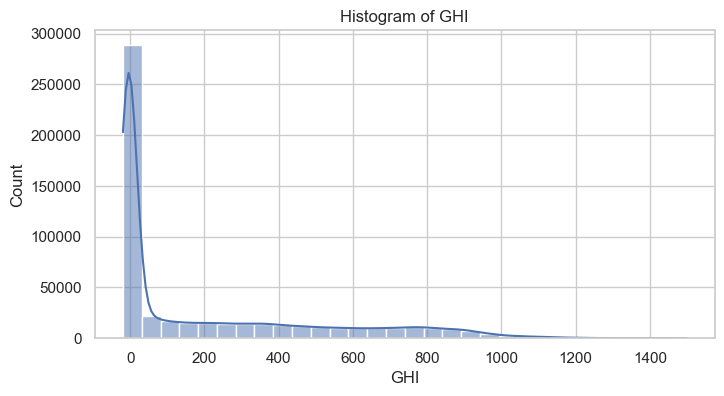

In [ ]:
# Histogram: GHI 
if 'GHI' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['GHI'].dropna(), bins=30, kde=True)
    plt.title('Histogram of GHI')
    plt.show()
else:
    print('GHI missing for histogram')

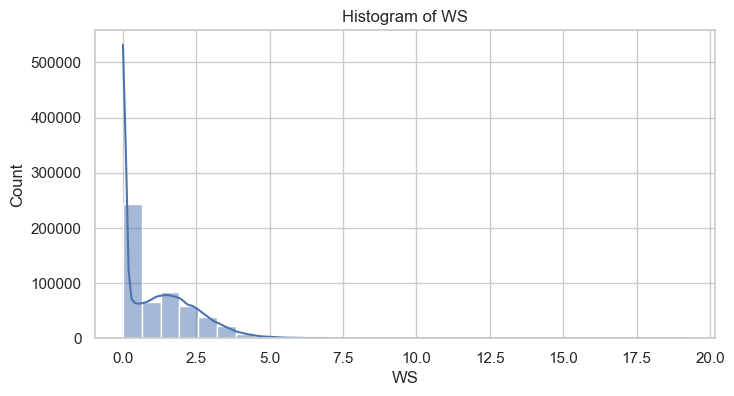

In [48]:
# Histogram: WS or ModA (fallback)
hist_col = 'WS' if 'WS' in df.columns else ('ModA' if 'ModA' in df.columns else None)
if hist_col:
    plt.figure(figsize=(8,4))
    sns.histplot(df[hist_col].dropna(), bins=30, kde=True)
    plt.title(f'Histogram of {hist_col}')
    plt.show()
else:
    print('No WS or ModA found for this histogram')

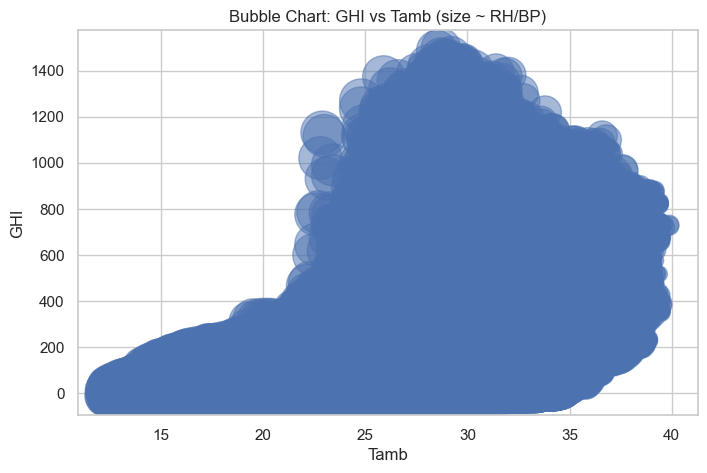

In [50]:
# Bubble chart: GHI vs Tamb, size ~ RH or BP
if 'GHI' in df.columns and 'Tamb' in df.columns:
    size_col = 'RH' if 'RH' in df.columns else ('BP' if 'BP' in df.columns else None)
    sizes = (df[size_col].fillna(0).clip(lower=0) + 1) * 10 if size_col else 30
    plt.figure(figsize=(8,5))
    plt.scatter(df['Tamb'], df['GHI'], s=sizes, alpha=0.5)
    plt.xlabel('Tamb')
    plt.ylabel('GHI')
    plt.title('Bubble Chart: GHI vs Tamb (size ~ RH/BP)')
    plt.show()
else:
    print('GHI or Tamb missing for bubble chart')